# Preliminaries
Write requirements to file, anytime you run it, in case you have to go back and recover dependencies.

Latest known such requirements are hosted for each notebook in the companion github repo, and can be pulled down and installed here if needed. Companion github repo is located at https://github.com/azunre/transfer-learning-for-nlp

In [1]:
!pip freeze > kaggle_image_requirements.txt

# Obtain Sample Tabular Datasets

 Let's first download a simple OpenML dataset of baseball stats...

In [2]:
!wget https://www.openml.org/data/get_csv/3622/dataset_189_baseball.arff # simple OpenML dataset

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2020-12-21 05:34:33--  https://www.openml.org/data/get_csv/3622/dataset_189_baseball.arff
Resolving www.openml.org (www.openml.org)... 131.155.11.11
Connecting to www.openml.org (www.openml.org)|131.155.11.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘dataset_189_baseball.arff’

dataset_189_basebal     [  <=>               ] 120.12K   423KB/s    in 0.3s    

2020-12-21 05:34:34 (423 KB/s) - ‘dataset_189_baseball.arff’ saved [123002]



Load and take a peek at the dataset

In [3]:
import pandas as pd
raw_baseball_data = pd.read_csv('dataset_189_baseball.arff', dtype=str) # .arff format is apprently mostly equivalent for .csv for our purposes (look up Weka if really curious)

# expand default pandas display options to make things more clearly visible when printed
pd.set_option('display.max_colwidth', 300)

print(raw_baseball_data.head())

         Player Number_seasons Games_played At_bats  Runs  Hits Doubles  \
0    HANK_AARON             23         3298   12364  2174  3771     624   
1   JERRY_ADAIR             13         1165    4019   378  1022     163   
2  SPARKY_ADAMS             13         1424    5557   844  1588     249   
3   BOBBY_ADAMS             14         1281    4019   591  1082     188   
4    JOE_ADCOCK             17         1959    6606   823  1832     295   

  Triples Home_runs  RBIs Walks Strikeouts Batting_average On_base_pct  \
0      98       755  2297  1402       1383           0.305       0.377   
1      19        57   366   208        499           0.254       0.294   
2      48         9   394   453        223           0.286       0.343   
3      49        37   303   414        447           0.269        0.34   
4      35       336  1122   594       1059           0.277       0.339   

  Slugging_pct Fielding_ave     Position Hall_of_Fame  
0        0.555         0.98     Outfield        

Let's also get another dataset, for reasons that will be very clear later. Without getting into too many details, we suffice it to mention here that this dataset will be used to expand our SIMOn classifier beyond the set of classes the pretrained model we will use was designed to detect.

This is a dataset of public library data in British Columbia, obtained from https://catalogue.data.gov.bc.ca/dataset/bc-public-libraries-statistics-2002-present and attached to this notebook, just to ensure it is available for readers of the book easily.

Let's display its path to make sure we know where it is.

In [4]:
!ls ../input/20022018-bc-public-libraries-open-data-v182 # see BC public libdary data 2002-2018 path

2002-2018-bc-public-libraries-open-data-csv-v18.2.csv


Let's load this dataset and take a peek

In [5]:
raw_data = pd.read_csv('../input/20022018-bc-public-libraries-open-data-v182/2002-2018-bc-public-libraries-open-data-csv-v18.2.csv', dtype=str)
print(raw_data.head())

   YEAR                           LOCATION                      LIB_NAME  \
0  2018  Alert Bay Public Library & Museum      Alert Bay Public Library   
1  2018       Beaver Valley Public Library  Beaver Valley Public Library   
2  2018        Bowen Island Public Library   Bowen Island Public Library   
3  2018             Burnaby Public Library        Burnaby Public Library   
4  2018          Burns Lake Public Library     Burns Lake Public Library   

                     LIB_TYPE SYMBOL        Federation             lib_ils  \
0  Public Library Association   BABM    Island Link LF     Evergreen Sitka   
1  Public Library Association   BFBV       Kootenay LF     Evergreen Sitka   
2           Municipal Library    BBI      InterLINK LF     Evergreen Sitka   
3           Municipal Library     BB      InterLINK LF  SirsiDynix Horizon   
4  Public Library Association   BBUL  North Central LF     Evergreen Sitka   

  POP_SERVED srv_pln STRAT_YR_START  ... OTH_EXP    TOT_EXP EXP_PER_CAPITA

Let's select a pair of columns to focus on (of type 'int' and 'percent')

In [6]:
COLUMNS = ["PCT_ELEC_IN_TOT_VOLS","TOT_AV_VOLS"] # lots of columns in this data set, let's just focus on these two
raw_library_data = raw_data[COLUMNS]
print(raw_library_data)

     PCT_ELEC_IN_TOT_VOLS TOT_AV_VOLS
0                  90.42%          57
1                  74.83%       2,778
2                  85.55%       1,590
3                   9.22%      83,906
4                  66.63%       4,261
...                   ...         ...
1202                0.00%      35,215
1203                0.00%     109,499
1204                0.00%         209
1205                0.00%      18,748
1206                0.00%        2403

[1207 rows x 2 columns]


# Preprocess Tabular Datasets

Install SIMOn as a first step.

In [7]:
!pip install git+https://github.com/algorine/simon

  Cloning https://github.com/algorine/simon to /tmp/pip-req-build-5ea_wtpz
  Running command git clone -q https://github.com/algorine/simon /tmp/pip-req-build-5ea_wtpz
     |████████████████████████████████| 1.1MB 4.3MB/s 
     |████████████████████████████████| 83.1MB 53.2MB/s 
     |████████████████████████████████| 81kB 3.3MB/s 
     |████████████████████████████████| 3.1MB 30.2MB/s 
  Created wheel for Simon: filename=Simon-1.2.4-cp36-none-any.whl size=114957662 sha256=acccdedebd6e6a0c986868c461113cf621e9c90a36087eb2b1b0c1922845fd19
  Stored in directory: /tmp/pip-ephem-wheel-cache-0pvlt57s/wheels/45/18/6e/2d0604c9f019344d262fe0caed95387bec7243cbb0aed7daac
Successfully built Simon
ERROR: ethnicolr 0.2.1 has requirement tensorflow==1.12.3, but you'll have tensorflow 1.12.0 which is incompatible.
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow 1.14.0
    

Make the required imports

In [8]:
from Simon import Simon # SIMOn model class 
from Simon.Encoder import Encoder # SIMOn data encoder class

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

Now, let's download a basic pretrained SIMOn model

In [9]:
!wget https://raw.githubusercontent.com/algorine/simon/master/Simon/scripts/pretrained_models/Base.pkl # pretrained SIMOn model configuration - Encoder, etc
!wget https://raw.githubusercontent.com/algorine/simon/master/Simon/scripts/pretrained_models/text-class.17-0.04.hdf5 # corresponding model weights
!ls

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2020-12-21 05:35:46--  https://raw.githubusercontent.com/algorine/simon/master/Simon/scripts/pretrained_models/Base.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1289 (1.3K) [application/octet-stream]
Saving to: ‘Base.pkl’

Base.pkl            100%[===================>]   1.26K  --.-KB/s    in 0s      

2020-12-21 05:35:46 (37.1 MB/s) - ‘Base.pkl’ saved [1289/1289]

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2020-12-21 05:35:46--  https://raw.githubusercontent.com/algorine/simon/master/Simon/scripts/pretrained_models/text-class.17-0.04.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.

Next, we want to load the SIMOn model

First load configurations and encoder

In [10]:
checkpoint_dir = "" # model weight are at the current level
execution_config = "Base.pkl" # name of our pretrained model configuration that was downloaded

Classifier = Simon(encoder={}) # create text classifier instance for loading encoder from model configs
config = Classifier.load_config(execution_config, checkpoint_dir) # load model config
encoder = config['encoder'] # get encoder
checkpoint = config['checkpoint'] # get checkpoint name

print(checkpoint) # the name of the checkpoint is stored in config as well, here we double-check it to make sure we got the right one

text-class.17-0.04.hdf5


/opt/conda/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.18.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator MultiLabelBinarizer from version 0.18.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Next, we define some hyperparameters to model data

In [11]:
max_len = 20 # maximum length of each tabular cell
max_cells = encoder.cur_max_cells # 500, maximum number of cells in a column
print(max_cells)

500


What are the pretrained categories?

In [12]:
Categories = encoder.categories
category_count = len(Categories) # number of handled categories
print(encoder.categories)

['address', 'boolean', 'datetime', 'email', 'float', 'int', 'phone', 'text', 'uri']


# Encode Data as Numbers

We "standardize" the data into the expected length, i.e.:

*truncate columns that are too long and replicate cells in shorter columns such that all columns are of length max_cells*

This is necessary because convolutional neural networks require a fixed length input

We also convert the data from a DataFrame into a Numpy array, and transpose it such that the first dimension corresponds to sample columns, as per convention

All these steps are accomplished within the function *encodeDataFrame*


Handle baseball data first:

In [13]:
X_baseball = encoder.encodeDataFrame(raw_baseball_data) # encode data (standardization, transposition, conversion to Numpy array)

print(X_baseball[0].shape)
print(X_baseball.shape) # display shape of encoded data
print(X_baseball[0]) # display encoded first column

(500, 20)
(18, 500, 20)
[[-1 -1 -1 ... 50 37 44]
 [-1 -1 -1 ... 54 41 46]
 [-1 -1 -1 ... 37 52 55]
 ...
 [-1 -1 -1 ... 49 45 46]
 [-1 -1 -1 ... 51 54 43]
 [-1 -1 -1 ... 38 37 43]]


Handle library data next:

In [14]:
X_library = encoder.encodeDataFrame(raw_library_data) # encode data (standardization, transposition, conversion to Numpy array)

print(X_library[0])
print(X_library[0].shape)
print(X_library.shape)

[[-1 -1 -1 ... 14 16 25]
 [-1 -1 -1 ... 14 20 23]
 [-1 -1 -1 ... 14 21 24]
 ...
 [-1 -1 -1 ... 16 14 16]
 [-1 -1 -1 ... 14 17 22]
 [-1 -1 -1 ... 14 20 23]]
(500, 20)
(2, 500, 20)


Generate some representative simulated data for illustrative purposes. The downloaded pretrained model was first trained on data of this sort, before transferring to a smaller set of hand-labeled examples

In [15]:
from Simon.DataGenerator import DataGenerator # Simulated/Fake data generation utility (using the library Faker)

# define appropriate parameters for the simulated data
data_cols = 5 # number of columns to generate
data_count = 10 # number if cells/rows per column

try_reuse_data = False # don't reuse data
simulated_data, header = DataGenerator.gen_test_data((data_count, data_cols), try_reuse_data)

print("SIMULATED DATA:") # display results
print(simulated_data)
print("SIMULATED DATA HEADER:")
print(header)

creating data
SIMULATED DATA:
[['Possible machine less before require suddenly.' 'PhD' 'search/app/tag'
  '27' '9']
 ['Main who ask must letter own become.' 'Jr.' 'main' '996' '5']
 ['Animal station as few sure entire pretty customer.' 'DDS' 'blog'
  '1435' '7']
 ['Program walk audience four report price cold.' 'MD' 'categories/posts'
  '2429' '6']
 ['Onto clearly newspaper certain.' 'DVM' 'explore/wp-content' '3555' '3']
 ['Side whatever center figure always everybody.' 'DVM'
  'tag/explore/wp-content' '653' '9']
 ['Concern choice western.' 'DDS' 'posts' '7090' '2']
 ['Single let none share.' 'Jr.' 'main/list/explore' '6413' '5']
 ['Game staff live situation likely stage think.' 'PhD' 'category/main'
  '5315' '5']
 ['Safe mind just every sing indicate.' 'II' 'main/main/categories'
  '3393' '7']]
SIMULATED DATA HEADER:
[['text']
 ['text']
 ['text']
 ['int']
 ['int']]


# Generate Model and Predict Tabular Data Column Types

Generate model, load weights into it, compile it...

In [16]:
model = Classifier.generate_model(max_len, max_cells, category_count) # generate model

Classifier.load_weights(checkpoint, None, model, checkpoint_dir) # load weights

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) # compile model

/opt/conda/lib/python3.6/site-packages/Simon/Simon.py:133: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=40, kernel_size=1, strides=1, padding="valid", kernel_initializer="glorot_normal")`
  subsample_length=1)(embedded)
/opt/conda/lib/python3.6/site-packages/Simon/Simon.py:136: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  embedded = MaxPooling1D(pool_length=pool_length)(embedded)
/opt/conda/lib/python3.6/site-packages/Simon/Simon.py:133: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=200, kernel_size=3, strides=1, padding="valid", kernel_initializer="glorot_normal")`
  subsample_length=1)(embedded)
/opt/conda/lib/python3.6/site-packages/Simon/Simon.py:133: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=1000, kernel_size=3, strides=1, padding="valid", kernel_initializer="glorot_normal")`
  subsamp

Checkpoint : text-class.17-0.04.hdf5


Define decision threshold, display model architecture

In [17]:
p_threshold = 0.5 # probability threshold for deciding membership of class

model.summary() # display model architecture

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 20)      0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 500, 512)     3202416     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 128)          328192      time_distributed_1[0][0]         
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 128)          328192      time_distributed_1[0][0]         
__________________________________________________________________________________________________
concatenat

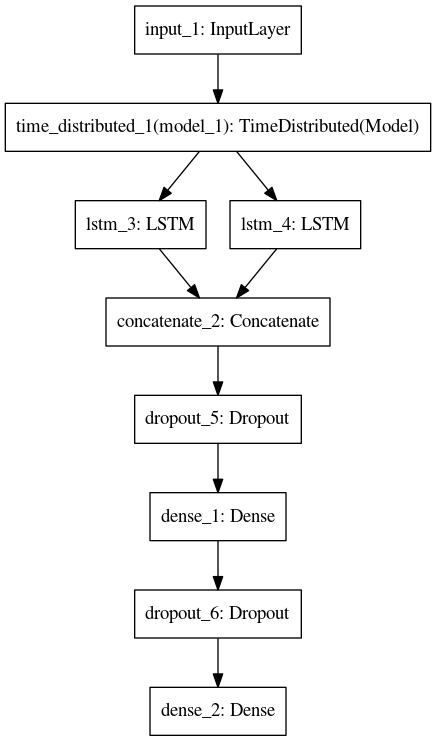

In [18]:
# alternative visualizationm method
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model.png') # visualize model architecture (for display here)
plot_model(model,to_file='model.svg') # higher resolution version for later

from IPython.display import Image # display image in notebook
Image(retina=True, filename='model.png') 

Make prediction for the OpenML baseball dataset

In [19]:
!ls

Base.pkl	    dataset_189_baseball.arff	   model.svg
__notebook__.ipynb  kaggle_image_requirements.txt  text-class.17-0.04.hdf5
data		    model.png			   unencoded_chars.json


In [20]:
y = model.predict(X_baseball) # predict classes
result = encoder.reverse_label_encode(y,p_threshold) # reverse encode labels
print("Recall that the column headers were:") # display the output
print(list(raw_baseball_data))
print("The predicted classes and probabilities are respectively:")
print(result)

Recall that the column headers were:
['Player', 'Number_seasons', 'Games_played', 'At_bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home_runs', 'RBIs', 'Walks', 'Strikeouts', 'Batting_average', 'On_base_pct', 'Slugging_pct', 'Fielding_ave', 'Position', 'Hall_of_Fame']
The predicted classes and probabilities are respectively:
([('text',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('float',), ('float',), ('float',), ('float',), ('text',), ('int',)], [[0.9970826506614685], [0.9877430200576782], [0.9899477362632751], [0.9903284907341003], [0.9894667267799377], [0.9854978322982788], [0.9892633557319641], [0.9895514845848083], [0.989467203617096], [0.9895854592323303], [0.9896339178085327], [0.9897230863571167], [0.9998295307159424], [0.9998230338096619], [0.9998272061347961], [0.9998039603233337], [0.9975670576095581], [0.9894945025444031]])


Make a prediction on the BC library, and let's look at it

In [21]:
X = encoder.encodeDataFrame(raw_library_data) # encode data using original frame
y = model.predict(X) # predict classes

result = encoder.reverse_label_encode(y,p_threshold) # reverse encode labels

print("Recall that the column headers were:")
print(list(raw_library_data))
print("The predicted class/probability:")
print(result)

Recall that the column headers were:
['PCT_ELEC_IN_TOT_VOLS', 'TOT_AV_VOLS']
The predicted class/probability:
([('text',), ('int',)], [[0.7253058552742004], [0.7712462544441223]])


Gets integer column right, but percent is recognized as "text". This is because that class was not trained for in the current model... 

Let's try fine-tuning the float category to detect percentages... 

The percent column here is rather large - ~1200 rows, which can be broken up into >50 columns if each one is length 20  

In [22]:
# let's recall what the raw library data columns look like
print(raw_library_data)
print(raw_library_data.shape)

     PCT_ELEC_IN_TOT_VOLS TOT_AV_VOLS
0                  90.42%          57
1                  74.83%       2,778
2                  85.55%       1,590
3                   9.22%      83,906
4                  66.63%       4,261
...                   ...         ...
1202                0.00%      35,215
1203                0.00%     109,499
1204                0.00%         209
1205                0.00%      18,748
1206                0.00%        2403

[1207 rows x 2 columns]
(1207, 2)


In [23]:
# turn into two lists
percent_value_list = raw_library_data['PCT_ELEC_IN_TOT_VOLS'].values.tolist()
int_value_list = raw_library_data['TOT_AV_VOLS'].values.tolist()

In [24]:
# Break it up into individual sample columns of size 20 cells each
original_length = raw_data.shape[0] # original length, 1207
chunk_size = 20 # length of each newly generated column
header_list = list(range(2*original_length//chunk_size)) # list of indices of new columns
new_raw_data = pd.DataFrame(columns = header_list) # initialize new DataFrame to hold new data
for i in range(original_length//chunk_size): # populate new DataFrame
    new_raw_data[i] = percent_value_list[i:i+chunk_size] # percent
    new_raw_data[original_length//chunk_size+i] = int_value_list[i:i+chunk_size] # integer
print(new_raw_data.head())

      0       1       2       3       4       5       6       7       8    \
0  90.42%  74.83%  85.55%   9.22%  66.63%  25.77%  54.02%  75.51%   7.60%   
1  74.83%  85.55%   9.22%  66.63%  25.77%  54.02%  75.51%   7.60%  55.17%   
2  85.55%   9.22%  66.63%  25.77%  54.02%  75.51%   7.60%  55.17%  70.02%   
3   9.22%  66.63%  25.77%  54.02%  75.51%   7.60%  55.17%  70.02%  55.94%   
4  66.63%  25.77%  54.02%  75.51%   7.60%  55.17%  70.02%  55.94%  76.25%   

      9    ...     110    111    112    113    114      115      116      117  \
0  55.17%  ...  34,596  1,077  2,334  9,401  6,424    2,649    1,118    8,699   
1  70.02%  ...   1,077  2,334  9,401  6,424  2,649    1,118    8,699      552   
2  55.94%  ...   2,334  9,401  6,424  2,649  1,118    8,699      552  117,282   
3  76.25%  ...   9,401  6,424  2,649  1,118  8,699      552  117,282      454   
4  69.58%  ...   6,424  2,649  1,118  8,699    552  117,282      454    7,134   

       118      119  
0      552  117,282  
1  117

In [25]:
# let's create a corresponding header for our training data
header = [("percent",),]*(original_length//chunk_size)
header.extend([("int",),]*(original_length//chunk_size))
print(header)

[('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('percent',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',), ('int',),

In [26]:
# new categories
print(encoder.categories)

['address', 'boolean', 'datetime', 'email', 'float', 'int', 'phone', 'text', 'uri']


In [27]:
import numpy as np

# but first grab last layer weights for initialization
print("WEIGHTS::")
old_weights = model.layers[8].get_weights()
print(old_weights[1]) # biases
print("Layer Name::")
print(model.layers[8].name) # name of last layer
print("SHAPE::")
print(model.layers[8].get_weights()[0].shape) # shape of weight matrix in last layer

WEIGHTS::
[-0.27894253  0.0348286   0.04099413 -0.26160368 -0.22156966 -0.11428836
 -0.15646574 -0.20444234 -0.1889774 ]
Layer Name::
dense_2
SHAPE::
(128, 9)


In [28]:
# find old weight index for closest category - text
old_category_index = encoder.categories.index('text')

# update the encoder with new category list, sort it alphabetically, find index of new category
encoder.categories.append("percent")
encoder.categories.sort()
new_category_index = encoder.categories.index('percent')

print(encoder.categories)

['address', 'boolean', 'datetime', 'email', 'float', 'int', 'percent', 'phone', 'text', 'uri']


In [29]:
# perform the initialization
# the most similar class is text, as our experiment above showed, so we use that as a proxy for % when initializing
new_weights = np.copy(old_weights) # important to perform the copy operation

# initialize new weights
new_weights[0] = np.insert(new_weights[0], new_category_index, old_weights[0][:,old_category_index], axis=1) # weights
new_weights[1] = np.insert(new_weights[1], new_category_index, 0) # biases

new_weights[0].shape

(128, 10)

In [30]:
# rebuild model using new category_count in last layer
model = Classifier.generate_transfer_model(max_len, max_cells, category_count, category_count+1, checkpoint, checkpoint_dir) # generate model


# only the last layer should be trainable - this was already done by the function above, but we repeat for illustrative purposes
for layer in model.layers:
    layer.trainable = False
model.layers[-1].trainable = True

model.layers[8].set_weights(new_weights)

/opt/conda/lib/python3.6/site-packages/Simon/Simon.py:185: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=40, kernel_size=1, strides=1, padding="valid", kernel_initializer="glorot_normal")`
  subsample_length=1)(embedded)
/opt/conda/lib/python3.6/site-packages/Simon/Simon.py:188: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  embedded = MaxPooling1D(pool_length=pool_length)(embedded)
/opt/conda/lib/python3.6/site-packages/Simon/Simon.py:185: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=200, kernel_size=3, strides=1, padding="valid", kernel_initializer="glorot_normal")`
  subsample_length=1)(embedded)
/opt/conda/lib/python3.6/site-packages/Simon/Simon.py:185: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=1000, kernel_size=3, strides=1, padding="valid", kernel_initializer="glorot_normal")`
  subsamp

Checkpoint : text-class.17-0.04.hdf5


/opt/conda/lib/python3.6/site-packages/Simon/Simon.py:221: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  model = Model(input=document, output=output)


In [31]:
# compile model
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

# see updated model summary, pay attention to dimension of output layer
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 500, 20)      0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 500, 512)     3202416     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 128)          328192      time_distributed_2[0][0]         
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 128)          328192      time_distributed_2[0][0]         
__________________________________________________________________________________________________
concatenat

In [32]:
# encode data (standardization, transposition, conversion to Numpy array)
X = encoder.encodeDataFrame(new_raw_data)
print("Encoded data shape")
print(X.shape)

# encode labels
y = encoder.label_encode(header)

# visualize
print(y)

Encoded data shape
(120, 500, 20)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [33]:
# Prepare data in the expected format -> 60/30/10 train/validation/test data split
data = Classifier.setup_test_sets(X, y)

In [34]:
import time

# Train
batch_size = 4
nb_epoch = 10
start = time.time()
history = Classifier.train_model(batch_size, checkpoint_dir, model, nb_epoch, data) # train model
end = time.time()
print("Time for training is %f sec"%(end-start))

starting learning


/opt/conda/lib/python3.6/site-packages/Simon/Simon.py:317: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  nb_epoch=nb_epoch, shuffle=True, callbacks=[earlystop_cb, check_cb, loss_history, tbCallBack])


Train on 72 samples, validate on 36 samples
Epoch 1/10
72/72 [==============================] - 12s 164ms/step - loss: 0.3015 - acc: 0.8792 - val_loss: 0.1493 - val_acc: 0.9194
Epoch 2/10
72/72 [==============================] - 11s 154ms/step - loss: 0.2389 - acc: 0.8931 - val_loss: 0.1067 - val_acc: 0.9556
Epoch 3/10
72/72 [==============================] - 11s 154ms/step - loss: 0.1604 - acc: 0.9208 - val_loss: 0.0816 - val_acc: 0.9917
Epoch 4/10
72/72 [==============================] - 11s 153ms/step - loss: 0.1180 - acc: 0.9486 - val_loss: 0.0665 - val_acc: 0.9917
Epoch 5/10
72/72 [==============================] - 11s 150ms/step - loss: 0.1007 - acc: 0.9542 - val_loss: 0.0574 - val_acc: 0.9944
Epoch 6/10
72/72 [==============================] - 11s 149ms/step - loss: 0.0839 - acc: 0.9736 - val_loss: 0.0512 - val_acc: 0.9944
Epoch 7/10
72/72 [==============================] - 11s 153ms/step - loss: 0.0820 - acc: 0.9736 - val_loss: 0.0476 - val_acc: 0.9944
Epoch 8/10
72/72 [=======

Visualize convergence

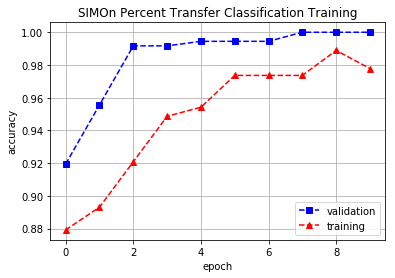

In [35]:
import matplotlib.pyplot as plt

df_history = pd.DataFrame(history.history)

fig,ax = plt.subplots()
plt.plot(range(df_history.shape[0]),df_history['val_acc'],'bs--',label='validation')
plt.plot(range(df_history.shape[0]),df_history['acc'],'r^--',label='training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('SIMOn Percent Transfer Classification Training')
plt.legend(loc='best')
plt.grid()
plt.show()
# Save figures
fig.savefig('SIMOnConvergence.eps', format='eps')
fig.savefig('SIMOnConvergence.pdf', format='pdf')
fig.savefig('SIMOnConvergence.png', format='png')
fig.savefig('SIMOnConvergence.svg', format='svg')

In [36]:
# Test trained model on test set
y = model.predict(data.X_test) # predict classes
result = encoder.reverse_label_encode(y,p_threshold) # reverse encode labels
print("The predicted classes and probabilities are respectively:")
print(result)
print("True labels/probabilities, for comparision:")
print(encoder.reverse_label_encode(data.y_test,p_threshold))

The predicted classes and probabilities are respectively:
([('int',), ('int',), ('percent',), ('int',), ('percent',), ('percent',), ('percent',), ('int',), ('int',), ('int',), ('percent',), ('percent',)], [[0.9885643124580383], [0.682071328163147], [0.8383817672729492], [0.9666174650192261], [0.769138514995575], [0.8510459065437317], [0.7784334421157837], [0.8306925892829895], [0.6296886801719666], [0.6862308382987976], [0.7836548089981079], [0.7770082950592041]])
True labels/probabilities, for comparision:
([('int',), ('int',), ('percent',), ('int',), ('percent',), ('percent',), ('percent',), ('int',), ('int',), ('int',), ('percent',), ('percent',)], [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]])


In [37]:
X = encoder.encodeDataFrame(raw_library_data) # repeat test on the raw two columns, as a final check
y = model.predict(X) # predict classes

result = encoder.reverse_label_encode(y,p_threshold) # reverse encode labels

print("The predicted class/probability:")
print(result)

The predicted class/probability:
([('percent',), ('int',)], [[0.7626379132270813], [0.9979692101478577]])


In [38]:
# Make figures downloadable to local system in interactive mode
from IPython.display import HTML
def create_download_link(title = "Download file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

create_download_link(filename='SIMOnConvergence.svg')